<a href="https://colab.research.google.com/github/saleamlakw/Phishing-URL-Detection/blob/main/Phishing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Necessary Libraries**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle
pd.set_option('display.max_columns', None)
from google.colab import drive
import os

**Loading and previewing data**

In [8]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:

data = pd.read_csv(os.path.join("/content/drive/MyDrive/Phishing Detection/", 'dataset_phishing.csv'))
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate


In [11]:
data.isna().sum()

,0
url,0
length_url,0
length_hostname,0
ip,0
nb_dots,0
...,...
web_traffic,0
dns_record,0
google_index,0
page_rank,0


In [13]:
# removing missing values

data.dropna(inplace=True)

In [14]:
features = [
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq',
    'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn',
    'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
    'ratio_digits_host', 'punycode', 'shortening_service', 'path_extension', 'phish_hints', 'domain_in_brand',
    'brand_in_subdomain', 'brand_in_path', 'suspecious_tld'
]

In [16]:
# target feature mapping

data['status'] = data['status'].map({'phishing': 1, 'legitimate': 0})

In [17]:
data['status'].value_counts()

,count
status,
0,5715
1,5715


In [18]:
data.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.0,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.00000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,0.322660,0.006649,0.123097,4.289589,0.000700,1.027909,0.004024,0.062292,0.001925,0.034821,0.448469,0.127997,0.006562,0.016710,0.610936,0.053137,0.025024,0.000350,0.002362,0.065617,0.050131,0.021610,2.231671,0.202450,0.083290,0.123447,0.000175,0.498250,0.003150,6.232808,2.927472,3.127297,5.019773,2.398950,15.393876,10.467979,10.561505,7.258882,7.678075,5.092425,0.327734,0.104199,0.004112,0.004899,0.017935,0.059755,87.189764,0.602457,0.276720,0.0,0.784864,0.0,0.158926,0.0,0.062469,0.063605,0.442170,51.978211,0.0,42.870444,23.236293,0.0,0.001312,0.006037,37.063922,0.001137,0.00140,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739,0.500000
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,1.093336,0.081274,1.466450,1.882251,0.026448,0.240325,0.103240,0.598190,0.077111,0.375576,0.501912,0.379008,0.080742,0.169358,0.487559,0.089363,0.093422,0.018705,0.048547,0.247622,0.218225,0.145412,0.637069,0.401843,0.276332,0.328964,0.013227,0.691907,0.056035,5.572355,4.768936,2.211571,3.941580,2.997809,22.083644,4.932015,23.077883,4.145827,3.578435,7.147050,0.842600,0.305533,0.063996,0.069827,0.132722,0.331266,166.758254,0.376474,0.319958,0.0,2.758802,0.0,0.266437,0.0,0.156209,0.244058,0.496666,41.523144,0.0,46.249897,38.386577,0.0,0.036204,0.077465,39.073385,0.033707,0.03739,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955,0.500022
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.0000

In [19]:
data.shape

(11430, 89)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [24]:
# Select only the numerical columns from the dataframe
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix on the numerical columns
corr_matrix = numerical_data.corr()

In [27]:
status_corr = corr_matrix['status']
status_corr.shape

(88,)

In [28]:
# Function for selecting features that are above than threshold value

def feature_selector_correlation(cmatrix, threshold):

    selected_features = []
    feature_score = []
    i=0
    for score in cmatrix:
        if abs(score)>threshold:
            selected_features.append(cmatrix.index[i])
            feature_score.append( ['{:3f}'.format(score)])
        i+=1
    result = list(zip(selected_features,feature_score))
    return result

In [29]:
features_selected = feature_selector_correlation(status_corr, 0.2)
features_selected

[('length_url', ['0.248580']),
 ('length_hostname', ['0.238322']),
 ('ip', ['0.321698']),
 ('nb_dots', ['0.207029']),
 ('nb_qm', ['0.294319']),
 ('nb_eq', ['0.233386']),
 ('nb_slash', ['0.242270']),
 ('nb_www', ['-0.443468']),
 ('ratio_digits_url', ['0.356395']),
 ('ratio_digits_host', ['0.224335']),
 ('tld_in_subdomain', ['0.208884']),
 ('prefix_suffix', ['0.214681']),
 ('shortest_word_host', ['0.223084']),
 ('longest_words_raw', ['0.200147']),
 ('longest_word_path', ['0.212709']),
 ('phish_hints', ['0.335393']),
 ('nb_hyperlinks', ['-0.342628']),
 ('ratio_intHyperlinks', ['-0.243982']),
 ('empty_title', ['0.207043']),
 ('domain_in_title', ['0.342807']),
 ('domain_age', ['-0.331889']),
 ('google_index', ['0.731171']),
 ('page_rank', ['-0.511137']),
 ('status', ['1.000000'])]

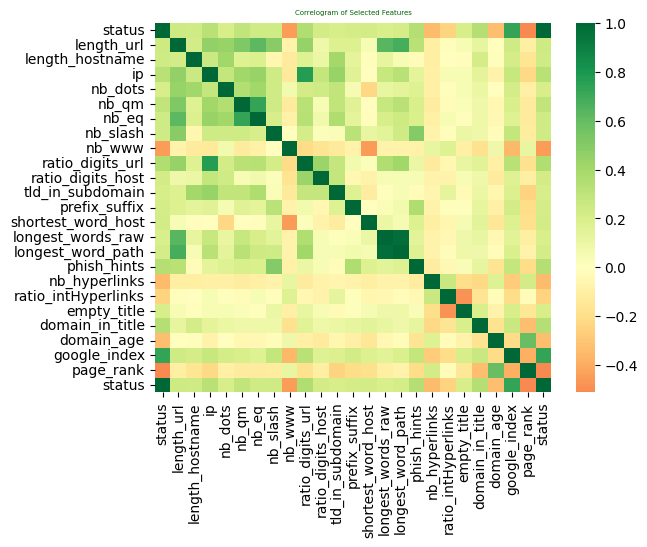

In [34]:
# Create a new DataFrame with only the selected features and the target variable
selected_features_df = data[['status'] + [feature[0] for feature in features_selected]]

# Compute the correlation matrix on the selected features
corr_matrix_selected = selected_features_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix_selected, cmap='RdYlGn',  center=0)
plt.title('Correlogram of Selected Features', fontsize=5, color='darkgreen')
plt.show()


In [36]:
selected_features = []
for feature, score in features_selected:
    if feature != 'status':
        selected_features.append(feature)
selected_features

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_qm',
 'nb_eq',
 'nb_slash',
 'nb_www',
 'ratio_digits_url',
 'ratio_digits_host',
 'tld_in_subdomain',
 'prefix_suffix',
 'shortest_word_host',
 'longest_words_raw',
 'longest_word_path',
 'phish_hints',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'empty_title',
 'domain_in_title',
 'domain_age',
 'google_index',
 'page_rank']

**Train Test Split & Feature Scaling**

In [38]:
X = data[selected_features]
y = data['status']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Model Training**

In [42]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

In [43]:
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7,9],
        'p': [1, 2]
    }
}

In [44]:
results = {}
for name, clf in classifiers.items():
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    results[name] = grid_search

In [45]:
for name, grid_search in results.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print()

Logistic Regression:
Best Parameters: {'C': 10}
Best Score: 0.9321055550074672
Test Accuracy: 0.9384184744576627
Confusion Matrix:
 [[1332   90]
 [  86 1350]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1422
           1       0.94      0.94      0.94      1436

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94      0.94      0.94      2858


Random Forest:
Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Best Score: 0.9613868297777521
Test Accuracy: 0.9597620713785864
Confusion Matrix:
 [[1363   59]
 [  56 1380]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1422
           1       0.96      0.96      0.96      1436

    accuracy                           0.96      2858
   macro avg       0.96      0.96      0.96      2858
weighted av

In [46]:
print("Summary of Best Models:")
for name, grid_search in results.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score (CV):", grid_search.best_score_)
    print()

Summary of Best Models:
Logistic Regression:
Best Parameters: {'C': 10}
Best Score (CV): 0.9321055550074672

Random Forest:
Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Best Score (CV): 0.9613868297777521

Gradient Boosting:
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best Score (CV): 0.9590533796449069

SVM:
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score (CV): 0.9564866253219074

KNN:
Best Parameters: {'n_neighbors': 3, 'p': 1}
Best Score (CV): 0.9510034665641551



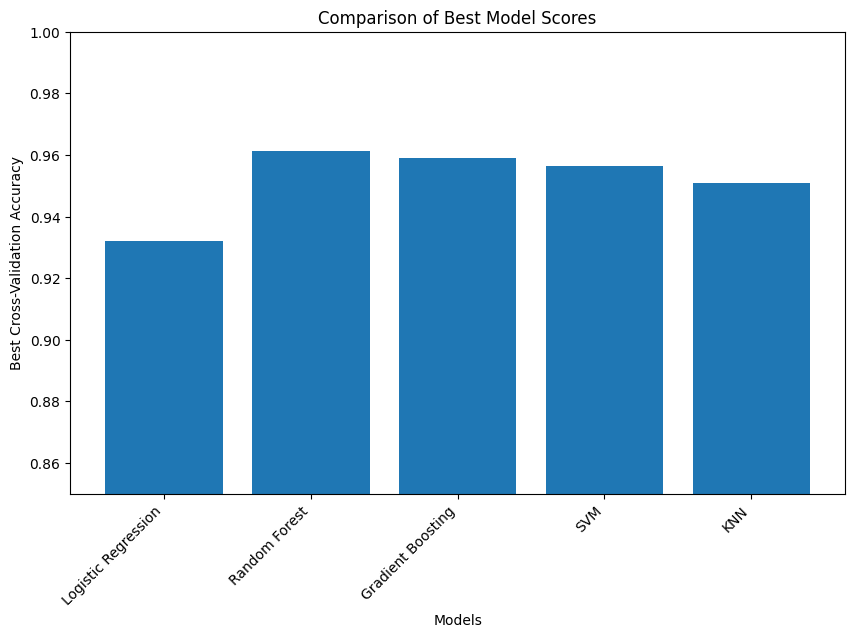

In [47]:
import matplotlib.pyplot as plt
model_names = list(results.keys())
best_scores = [results[name].best_score_ for name in model_names]

plt.figure(figsize=(10, 6))
plt.bar(model_names, best_scores)
plt.xlabel("Models")
plt.ylabel("Best Cross-Validation Accuracy")
plt.title("Comparison of Best Model Scores")
plt.ylim(0.85, 1.0)  # Adjust y-axis limits if needed
plt.xticks(rotation=45, ha="right")
plt.show()


In [48]:
model=RandomForestClassifier(max_depth=20,n_estimators=100)
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=20)

In [49]:
with open('phishing_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)